In [6]:
import torchdrug as td
from torchdrug import data
%matplotlib inline

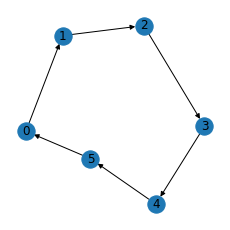

In [13]:
# 构图
edge_list = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]]
graph = data.Graph(edge_list, num_node=6)
graph.visualize()

torch.Size([6, 69])
torch.Size([12, 19])


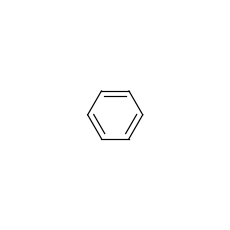

In [14]:
# 分子
mol = data.Molecule.from_smiles("C1=CC=CC=C1")
mol.visualize()
print(mol.node_feature.shape)
print(mol.edge_feature.shape)

/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/molecule.py:858: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], num_relation=4, device='cuda:0')


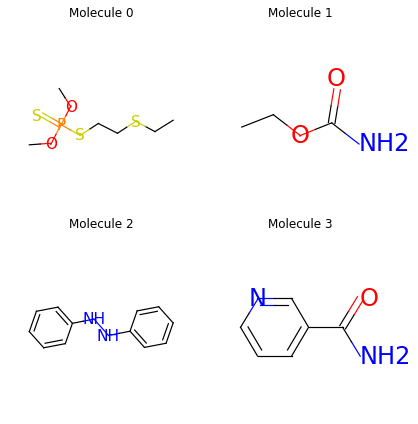

In [15]:
# 从 SMILES 到 mol
smiles_list = ["CCSCCSP(=S)(OC)OC", "CCOC(=O)N",
               "N(Nc1ccccc1)c2ccccc2", "NC(=O)c1cccnc1"]
mols = data.PackedMolecule.from_smiles(smiles_list)
mols.visualize()
mols = mols.cuda()
print(mols)

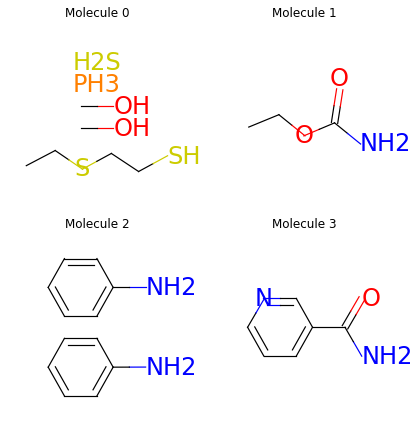

In [16]:
# Operations on mol
node_in, node_out, bond_type = mols.edge_list.t()
edge_mask = (mols.atom_type[node_in] == td.CARBON) | \
            (mols.atom_type[node_out] == td.CARBON)
mols = mols.edge_mask(edge_mask)
mols.visualize()

# A Molecule Classifier

In [19]:
import torch
from torchdrug import datasets

In [20]:
dataset = datasets.ClinTox(".cache/molecule-datasets/")

15:10:18   Downloading http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/clintox.csv.gz to /home/seeyou/molecule-datasets/clintox.csv.gz
15:10:19   Extracting /home/seeyou/molecule-datasets/clintox.csv.gz to /home/seeyou/molecule-datasets/clintox.csv


Loading /home/seeyou/molecule-datasets/clintox.csv: 100%|██████████| 1485/1485 [00:00<00:00, 122037.33it/s]
Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
RDKit ERROR: [15:10:19] Explicit valence for atom # 0 N, 5, is greater than permitted
/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
[15:10:19] Explicit valence for atom # 0 N, 5, is greater than permitted
/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x

In [21]:
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]

In [22]:
lengths += [len(dataset) - sum(lengths)]

In [23]:
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

In [24]:
from torchdrug import core, models, tasks

In [25]:
model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)

In [26]:
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

In [27]:
# Train
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     batch_size=1024)
solver.train(num_epoch=100)

15:11:26   Preprocess training set
15:11:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:11:26   Epoch 0 begin
15:11:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:11:39   binary cross entropy: 5.89174
15:11:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:11:39   Epoch 0 end
15:11:39   duration: 12.73 secs
15:11:39   speed: 0.16 batch / sec
15:11:39   ETA: 21.00 mins
15:11:39   max GPU memory: 0.1 MiB
15:11:39   ------------------------------
15:11:39   average binary cross entropy: 4.10233
15:11:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:11:39   Epoch 1 begin
15:11:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:11:40   Epoch 1 end
15:11:40   duration: 1.16 secs
15:11:40   speed: 1.72 batch / sec
15:11:40   ETA: 11.35 mins
15:11:40   max GPU memory: 0.0 MiB
15:11:40   ------------------------------
15:11:40   average binary cross entropy: 3.54453
15:11:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:11:40   Epoch 2 begin
15:11:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:11:41   Epoch 2 end
15:11:41   duration: 1.25 secs
15:11:41   speed

In [29]:
# solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
#                      batch_size=1024, gpus=[0])
# solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
#                      batch_size=256, gpus=[0, 1, 2, 3])
# solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
#                      batch_size=1024, logger="wandb")

# Test the Model

In [30]:
solver.evaluate("valid")
batch = data.graph_collate(valid_set[:8])
pred = task.predict(batch)

15:13:28   Evaluate on valid
15:13:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:13:28   auprc [CT_TOX]: 0.121431
15:13:28   auprc [FDA_APPROVED]: 0.962472
15:13:28   auroc [CT_TOX]: 0.499101
15:13:28   auroc [FDA_APPROVED]: 0.57551


# Save and Load

In [32]:
import json

with open(".cache/clintox_gin.json", "w") as fout:
    json.dump(solver.config_dict(), fout)
solver.save(".cache/clintox_gin.pth")

15:14:02   Save checkpoint to .cache/clintox_gin.pth
